<a href="https://www.kaggle.com/code/joshuacurtiswebb/spx-option-backtester?scriptVersionId=130590118" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
import spx_strategies as ss
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/spx-option-spread-backtester/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)



#########################
# Settings for backtest #
#########################
# Delta values must be scaled from 0.0 to 1.0 (0 delta to 100 delta)
delta_sp = 0.214
delta_lp = 0.001
delta_sc = 0.201
delta_lc = 0.001
delta_params = {'delta_sp':delta_sp, 'delta_lp':delta_lp, 'delta_sc':delta_sc,'delta_lc':delta_lc}

same_day = False
purchase_time = '15:45:00'

# Max loss is % : max_loss * amount_collected is exit criteria
max_loss = 100

# In dollars
commission = 1.5

if same_day:
    dte_f = -1
else:
    dte_f = 0


files = [
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_0dte_all.csv", 
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_0dte_all.csv", 
#    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_0dte_all.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1545_1600.csv"
    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1545_1600.csv"
]
li = []
for f in files:   
    df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)
df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
df['delta'] = df['delta'].abs()

if 'dte' not in df:
    df['dte'] = ((df['expiration'] - df['quote_date']) / np.timedelta64(1, 'D')).astype('int')

initial_portfolio_value = df.loc[1,'price']*20

df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
df_ty['Date'] = pd.to_datetime(df_ty['Date'])

Copying db file to output : optimal-short-straddle-study_2021-2022_1DTE_1.db
Copying db file to output : optimal-iron-condor-study_2022_1.db
Copying db file to output : optimal-iron-condor-study.db


# New strategy schema focused on static and dynamic entry and exit policies

This code will be moved to a plugin notebook after it is stable

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from abc import ABC, abstractmethod

class AbstractStrategy(ABC):
    def __init__(self, entry_policy, exit_policy, df_ty, initial_portfolio_value, commission = 1.5, debug = False):
        self.entry_policy = entry_policy
        self.exit_policy = exit_policy
        self.commission = commission
        self.initial_portfolio_value = initial_portfolio_value
        self.df_ty = df_ty
        self.debug = debug
        self.df_trades = None
       
    def performCalcs(self):
        df_trades = self.df_trades
        df_trades['commission'] = df_trades['trade_count']*commission
        df_trades['lost'] = df_trades['lost_c'] + df_trades['lost_p']
        df_trades['net'] = df_trades['collected'] - df_trades['lost'] - df_trades['commission']
        df_trades['portfolio_value'] = 0.0
        #df_trades['daily_return'] = 0.0
        #df_trades['margin_utilization']=0.0
        initial_portfolio_value = self.initial_portfolio_value
        df_trades['net_cumsum']=df_trades['net'].cumsum()

        df_trades['portfolio_value'] = initial_portfolio_value + df_trades['net_cumsum']
        df_trades['transaction_return'] = df_trades['net'] / df_trades['portfolio_value'].shift(1)
        net = df_trades['net'].iloc[0]
        df_trades.loc[0,'transaction_return'] = df_trades['net'].iloc[0] / initial_portfolio_value
        df_trades['cum_return'] = (df_trades['portfolio_value'] - initial_portfolio_value) / initial_portfolio_value

        df_ty = self.df_ty.copy()
        df_ty['daily_risk_free_return'] = (df_ty['Adj Close'] / 252) / 100
        df_ty.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

        df_trades = pd.merge(df_trades, df_ty, left_on='trade_date', right_on='Date')
        df_trades.drop(['Date'],axis=1,inplace=True)

        # if you want to scale the chart, you should do it here
        factor = 1.0
        df_trade_plot = df_trades.copy()
        df_trade_plot['net'] = df_trade_plot['net']*factor
        df_trade_plot.set_index('expiration', inplace=True)
        df_trade_plot = df_trade_plot['net'].cumsum()
        
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        secax = ax.secondary_yaxis('right', functions=(self.net2pct, self.pct2net))
        secax.set_ylabel('% return')
        df_trade_plot.plot(ax=ax)
        plt.title("\n".join(wrap(str(self),50)))
        plt.grid()
        plt.savefig(f"{str(self)}.png")
        if self.debug == False:
            plt.close(fig)

        df_trades_transaction_return = df_trades.copy()
        df_trades_transaction_return['transaction_return'] *= 100 
        df_trades_transaction_return.set_index('expiration', inplace=True)
        fig = plt.figure()
        ax = df_trades_transaction_return['transaction_return'].plot(linestyle='None', marker="o")
        ax.set_ylabel('Transaction Return %')
        plt.title("\n".join(wrap(str(self),50)))
        plt.grid()
        plt.savefig(f"daily_ret_{str(self)}.png")
        if self.debug == False:
            plt.close(fig)
        

        trade_count = df_trades.shape[0]
        win_count = df_trades[df_trades['net']>0].shape[0]
        loss_count = df_trades[df_trades['net']<0].shape[0]
        std_trans_return = df_trades['transaction_return'].std()
        std_trans_return_less_rf = (df_trades['transaction_return'] - df_trades['daily_risk_free_return']).std()
        self.df_trades = df_trades
        if self.debug:
            print("*****  BACKTEST RESULTS  ****")
            print(
                f"\n{'Cumulative return:':<35}{round(df_trades['cum_return'].iloc[-1]*100,3):>10} %",
                f"\n{'Max Drawdown:':<35}{round(df_trades['cum_return'].min()*100,3):>10} %",
                f"\n{'Trading Days:':<35}{trade_count:>10}",
                f"\n{'Wins:':<35}{win_count:>10}",
                f"\n{'Losses:':<35}{loss_count:>10}",
                f"\n{'Breakeven:':<35}{df_trades[df_trades['net']==0.0].shape[0]:>10}",
                f"\n{'Win/Loss Ratio:':<35}{round(win_count/trade_count*100,3):>10} %",
                f"\n{'Mean Win:':<35}{round(df_trades[df_trades['net']>0]['net'].mean(),3):>10} $",
                f"\n{'Mean Win Trans Return:':<35}{round(df_trades[df_trades['transaction_return']>0]['transaction_return'].mean()*100,3):>10} %",
                f"\n{'Mean Loss:':<35}{round(df_trades[df_trades['net']<0]['net'].mean(),3):>10} $",
                f"\n{'Mean Loss Trans Return:':<35}{round(df_trades[df_trades['transaction_return']<0]['transaction_return'].mean()*100,3):>10} %",
                f"\n{'Mean Net Trans:':<35}{round(df_trades['net'].mean(),3):>10} $",
                f"\n{'Mean Trans Return:':<35}{round(df_trades['transaction_return'].mean()*100,3):>10} %",
                f"\n{'Std Dev of Net Trans:':<35}{round(df_trades['net'].std(),3):>10}",
                f"\n{'Std Dev of Trans Return:':<35}{round(df_trades['transaction_return'].std(),3):>10}",
                f"\n{'Max Loss:':<35}{round(df_trades['net'].min(),3):>10} $",
                f"\n{'Max Win:':<35}{round(df_trades['net'].max(),3):>10} $",
                f"\n{'Sharpe Ratio static STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return,3):>10}",
                f"\n{'Sharpe Ratio with RF STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return_less_rf,3):>10}",
                f"\n{'Risk Adj Cumulative Return:':<35}{round(df_trades['cum_return'].iloc[-1]*100/std_trans_return,3):>10}",
                f"\n"
            )
        risk_adj_cum_return = round(df_trades['cum_return'].iloc[-1]*100/std_trans_return,3)
        return risk_adj_cum_return
        
    def net2pct(self,x):
        return (x / initial_portfolio_value)*100

    def pct2net(self,x):
        return initial_portfolio_value * x/100
        
    @abstractmethod
    def evaluate(self,df):
        pass
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass
    
class AbstractPolicy(ABC):
    def getRoundedSlippedPrice(self,bid,ask, trans_type):
        mid = (bid + ask)/0.02
        if mid % 1 != 0.0:
            # We need to slip the bid/ask spread
            if trans_type == 'sell':
                ask -= 0.05
            elif trans_type=='buy':
                bid += 0.05

        mid = round((bid + ask)/0.02,1)
        return mid
    
    def get_amount_lost(self,df,row):
        contract_date = row['expiration']
        df1 = df[(df['quote_date']==contract_date) & (df['expiration']==contract_date) & (df['quote_time']=='16:00:00')]
        underlying = df1['price']
        
        if len(underlying)==0:
            raise Exception(f"Fatal error. Underlying price not found for date : {contract_date} and time : '16:00:00'")
        
        underlying = underlying.iloc[0]
        
        total_lost_c = 0.0
        total_lost_p = 0.0
        for col in row.index.values:
            if 'strike_sc' in col and row[col] != 0.0 and underlying > row[col]:
                    total_lost_c = total_lost_c + (underlying - row[col])*100
            if 'strike_lc' in col and row[col] != 0.0 and underlying > row[col]:
                    total_lost_c = total_lost_c - (underlying - row[col])*100
            if 'strike_sp' in col and row[col] != 0.0 and underlying < row[col]:
                    total_lost_p = total_lost_p + (row[col] - underlying)*100
            if 'strike_lp' in col and row[col] != 0.0 and underlying < row[col]:
                    total_lost_p = total_lost_p - (row[col] - underlying)*100
        return pd.Series([total_lost_c, total_lost_p])

    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass
    
class AbstractEntryPolicy(AbstractPolicy):
    def __init__(self, commission):
        self.commission = commission
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass
    
class AbstractStaticEntryPolicy(AbstractEntryPolicy):
    def __init__(self,commission, dte, trade_time):
        self.dte = dte
        self.trade_time = trade_time
        super().__init__(commission)
    
    @abstractmethod
    def populateTrades(self, data):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass
    
class AbstractExitPolicy(AbstractPolicy):
    def __init__(self, commission):
        self.commission = commission
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass
    
class AbstractDynamicExitPolicy(AbstractExitPolicy):
    def __init__(self, commission, timestep):
        self.timestep = timestep
        super().__init__(commission)
    
    @abstractmethod
    def populateTrades(self, df):
        pass
    
    @abstractmethod
    def evaluateTradingCondition(self, time, df):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass
    

    
class AbstractStaticExitPolicy(AbstractExitPolicy):
    def __init__(self,commission, trade_time):
        self.trade_time = trade_time
        super().__init__(commission)
    
    @abstractmethod
    def populateTrades(self, df):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass
    
    
class ShortStraddleStaticEntryPolicy(AbstractStaticEntryPolicy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc):
        self.delta_sp = delta_sp
        self.delta_sc = delta_sc
        self.summary = f"Short Straddle. SP Delta : {delta_sp} SC Delta : {delta_sc}"
        super().__init__(commission, dte, trade_time)
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
    def get_contract_strike(self, curr_date, contract_date, target_delta, i_df, trans_type):
        # -1 means no delta should be selected
        if target_delta ==-1:
            return pd.Series([0,0,0])
#         df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)].min()
        df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)]
    
        if len(df1) == 0:
            print(f"No records found: {curr_date}, {contract_date}")
            return pd.Series([0,0,0])
        
        df1 = df1.iloc[0]
        rounded_price = self.getRoundedSlippedPrice(df1['ask'],df1['bid'],trans_type)

        
        return pd.Series([df1['strike'],df1['delta'],rounded_price])
    
    def populateTrades(self, df):
        df_exp = df.loc[df[df['dte']==self.dte].groupby('expiration')['dte'].idxmin()]
        df_dates = df_exp.loc[df_exp.groupby('quote_date')['dte'].idxmin()]
        last_date = df_dates['quote_date'].max()
        df_dates = df_dates[df_dates['expiration']<=last_date]
        df_trades = df_dates[['quote_date','expiration']].copy()
        df_trades.rename({'quote_date': 'trade_date'}, axis='columns', inplace=True)
        df_trades['trade_count'] = 0
        
        df_trades['delta_sc_target'] = self.delta_sc
        df_trades['delta_sp_target'] = self.delta_sp
        
        #TODO : Throw exception if no trades are found
        if df_trades.shape[0] == 0:
            print("***WARNING*** : No trades were found with static rules. Backtest results will not compute.")
        
        df['delta_sc_target'] = self.delta_sc
        df['delta_sp_target'] = self.delta_sp
        
        # create call/put dataframe slice if needed
        df_purchase_time = df[(df['quote_time'] == self.trade_time) & (df['dte']==self.dte)]
        df_c = df_purchase_time[(df_purchase_time['type']=="C")]
        df_p = df_purchase_time[(df_purchase_time['type']=="P")]
        
        if df_c.shape[0] == 0:
            print("***WARNING*** : No calls were found with static rules.")
            
        if df_p.shape[0] == 0:
            print("***WARNING*** : No calls were found with static rules.")
        
        ##### SHORT CALL #####
        df_sc = df_c[(df_c['delta']<= df_c['delta_sc_target'])]
        df_sc = df_sc.loc[df_sc.groupby(['quote_date'])[['delta']].idxmax()['delta']]
        df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sc_target'], df_sc,'sell'), axis = 1).T.values
        
        #### SHORT PUT ####
        df_sp = df_p[(df_p['delta']<= df_p['delta_sp_target'])]
        df_sp = df_sp.loc[df_sp.groupby(['quote_date'])[['delta']].idxmax()['delta']]
        df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sp_target'], df_sp,'sell'), axis = 1).T.values
        
            
        #TODO - clean this up. 
        for index, row in df_trades.iterrows():
            if df_trades.loc[index,'strike_sc'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_sp'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
                
        df_trades['collected'] = df_trades['collected_sc'] + df_trades['collected_sp'] 
        
        return df_trades
    
class ShortIronCondorStaticEntryPolicy(AbstractStaticEntryPolicy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc):
        self.delta_sp = delta_sp
        self.delta_sc = delta_sc
        self.delta_lp = delta_lp
        self.delta_lc = delta_lc
        self.summary = f"Short Iron Condor. SP Delta : {round(delta_sp,3)} SC Delta : {round(delta_sc,3)} LP Delta : {round(delta_lp,3)} LC Delta : {round(delta_lc,3)}"
        super().__init__(commission, dte, trade_time)
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
    def get_contract_strike(self, curr_date, contract_date, target_delta, i_df, trans_type):
        # -1 means no delta should be selected
        if target_delta ==-1:
            return pd.Series([0,0,0])
#         df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)].min()
        df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)]
    
        if len(df1) == 0:
            print(f"No records found: {curr_date}, {contract_date}")
            return pd.Series([0,0,0])
        
        df1 = df1.iloc[0]
        rounded_price = self.getRoundedSlippedPrice(df1['ask'],df1['bid'],trans_type)

        
        return pd.Series([df1['strike'],df1['delta'],rounded_price])
    
    def populateTrades(self, df):
        df_exp = df.loc[df[df['dte']==self.dte].groupby('expiration')['dte'].idxmin()]
        df_dates = df_exp.loc[df_exp.groupby('quote_date')['dte'].idxmin()]
        last_date = df_dates['quote_date'].max()
        df_dates = df_dates[df_dates['expiration']<=last_date]
        df_trades = df_dates[['quote_date','expiration']].copy()
        df_trades.rename({'quote_date': 'trade_date'}, axis='columns', inplace=True)
        df_trades['trade_count'] = 0
        
        df_trades['delta_sc_target'] = self.delta_sc
        df_trades['delta_sp_target'] = self.delta_sp
        df_trades['delta_lc_target'] = self.delta_lc
        df_trades['delta_lp_target'] = self.delta_lp
        
        #TODO : Throw exception if no trades are found
        if df_trades.shape[0] == 0:
            print("***WARNING*** : No trades were found with static rules. Backtest results will not compute.")
        
        df['delta_sc_target'] = self.delta_sc
        df['delta_sp_target'] = self.delta_sp
        df['delta_lc_target'] = self.delta_lc
        df['delta_lp_target'] = self.delta_lp
        
        # create call/put dataframe slice if needed
        df_purchase_time = df[(df['quote_time'] == self.trade_time) & (df['dte']==self.dte)]
        df_c = df_purchase_time[(df_purchase_time['type']=="C")]
        df_p = df_purchase_time[(df_purchase_time['type']=="P")]
        
        if df_c.shape[0] == 0:
            print("***WARNING*** : No calls were found with static rules.")
            
        if df_p.shape[0] == 0:
            print("***WARNING*** : No calls were found with static rules.")
        
        ##### SHORT CALL #####
        df_sc = df_c[(df_c['delta']<= df_c['delta_sc_target'])]
        df_sc = df_sc.loc[df_sc.groupby(['quote_date'])[['delta']].idxmax()['delta']]
        df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sc_target'], df_sc, 'sell'), axis = 1).T.values
        
        #### SHORT PUT ####
        df_sp = df_p[(df_p['delta']<= df_p['delta_sp_target'])]
        df_sp = df_sp.loc[df_sp.groupby(['quote_date'])[['delta']].idxmax()['delta']]
        df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sp_target'], df_sp, 'sell'), axis = 1).T.values
        
        ###### LONG CALL #####
        df_lc = df_c[(df_c['delta']>= df_c['delta_lc_target'])]# We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
        df_lc = df_lc.loc[df_lc.groupby(['quote_date'])[['delta']].idxmin()['delta']]
        df_trades['strike_lc'],df_trades['delta_lc'],df_trades['collected_lc'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_lc_target'], df_lc, 'buy'), axis = 1).T.values
        df_trades['collected_lc'] = df_trades['collected_lc']*-1
            
        ###### LONG PUT #####
        df_lp = df_p[(df_p['delta']>= df_p['delta_lp_target'])]
        df_lp = df_lp.loc[df_lp.groupby(['quote_date'])[['delta']].idxmin()['delta']]
        df_trades['strike_lp'],df_trades['delta_lp'],df_trades['collected_lp'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_lp_target'], df_lp, 'buy'), axis = 1).T.values
        df_trades['collected_lp']=df_trades['collected_lp']*-1
            
        #TODO - clean this up. 
        for index, row in df_trades.iterrows():
            if df_trades.loc[index,'strike_sc'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_sp'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_lc'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_sc'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_lp'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_sp'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
                
        df_trades['collected'] = df_trades['collected_sc'] + df_trades['collected_sp'] + df_trades['collected_lc'] + df_trades['collected_lp']
        
        return df_trades

class HoldToExpStaticExitPolicy(AbstractStaticExitPolicy):
    def __init__(self, commission, trade_time):
        self.summary = f"Hold Until Expiration"
        super().__init__(commission, trade_time)
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
    #Test if this is even needed, if no errors, the abstractpolicy one is working just fine
#     def get_amount_lost(self,df,row):
#         contract_date = row['expiration']
#         df1 = df[(df['quote_date']==contract_date) & (df['expiration']==contract_date) & (df['quote_time']=='16:00:00')]
#         underlying = df1['price']
        
#         if len(underlying)==0:
#             raise Exception(f"Fatal error. Underlying price not found for date : {contract_date} and time : '16:00:00'")
        
#         underlying = underlying.iloc[0]
        
#         total_lost_c = 0.0
#         total_lost_p = 0.0
#         for col in row.index.values:
#             if 'strike_sc' in col and row[col] != 0.0 and underlying > row[col]:
#                     total_lost_c = total_lost_c + (underlying - row[col])*100
#             if 'strike_lc' in col and row[col] != 0.0 and underlying > row[col]:
#                     total_lost_c = total_lost_c - (underlying - row[col])*100
#             if 'strike_sp' in col and row[col] != 0.0 and underlying < row[col]:
#                     total_lost_p = total_lost_p + (row[col] - underlying)*100
#             if 'strike_lp' in col and row[col] != 0.0 and underlying < row[col]:
#                     total_lost_p = total_lost_p - (row[col] - underlying)*100
#         return pd.Series([total_lost_c, total_lost_p])
    
    def populateTrades(self, df, df_trades):
        df_qt = df[(df['quote_time']==self.trade_time)&(df['dte']==0)]
        df_trades['lost_c'], df_trades['lost_p'] = df_trades.apply(
            lambda row : self.get_amount_lost(df_qt, row), axis=1).T.values
        return df_trades
    

    
class StaticEntryHoldToExpStrategy(AbstractStrategy):
    def __init__(self, commission, dte, trade_time, df_ty, ipv):
        entry_policy = AbstractStaticEntryPolicy(commission, dte, trade_time)
        exit_policy = AbstractStaticExitPolicy(commission, trade_time)
        self.summary = f"{str(entry_policy)} {str(exit_policy)}"
        super().__init__(entry_policy, exit_policy, df_ty, ipv, commission)
        
    def evaluate(df):
        self.df_trades = self.entry_policy.populateTrades(df)
        self.df_trades = self.exit_policy.populateTrades(df, self.df_trades)
        return self.performCalcs()
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class StaticEntryDynamicExitStrategy(AbstractStrategy):
    def __init__(self, commission, dte, trade_time, df_ty, ipv, timestep, debug = False):
            entry_policy = AbstractStaticEntryPolicy(commission, dte, trade_time)
            exit_policy = AbstractDynamicExitPolicy(commission, timestep)
            self.summary = f"{str(entry_policy)} {str(exit_policy)}"
            super().__init__(entry_policy, exit_policy, df_ty, ipv, commission, debug)

    def evaluate(self,df):
        self.df_trades = self.entry_policy.populateTrades(df)
        
        
        self.df_trades['lost_c'] = 0.0
        self.df_trades['lost_p'] = 0.0
        
        df_times = pd.DataFrame(df['quote_time'].unique())
        df_times[0] = pd.to_datetime(df_times[0], format='%H:%M:%S').dt.time
        df_times.rename(columns={0: "quote_time"},inplace=True)
        df_times = df_times.sort_values(by='quote_time')
        
        start_time_timer = perf_counter()
        for index, trow in df_times.iterrows():
            print(trow.iloc[0])
            # min_i = int(trow[0][3:5])
            
            min_i = int(trow[0].strftime("%M"))
            #curr_time = time(hour=int(trow[0][0:2]),minute=int(trow[0][3:5]),second=int(trow[0][6:]))
            curr_time = trow[0]
            start_time = time(hour=9, minute=45)
            end_time = time(hour=16)
            if (end_time < curr_time or curr_time <= start_time):
                continue
            str_quote_time = trow[0].strftime("%H:%M:%S")
            df_qt = df[(df['quote_time']==str_quote_time)]

            print(f"Num rows at {str_quote_time} : {df_qt.shape[0]}")

            self.df_trades['trade_count'],self.df_trades['lost_c'], self.df_trades['lost_p'] = self.df_trades.apply(
                lambda row : self.exit_policy.evaluateTradingCondition(str_quote_time, row, df_qt), axis=1).T.values
            stop_time_timer = perf_counter()
            # print(df_trades.head())

            if min_i % 30 == 0:
                print(f"Processed {curr_time} | Elapsed : {stop_time_timer - start_time_timer}")
                start_time_timer = stop_time_timer
        
        return self.performCalcs()


    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class StaticShortIronCondorDynamicMaxLossExitStrategy(StaticEntryDynamicExitStrategy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc, df_ty, ipv, timestep, max_loss, debug = False):
        self.entry_policy = ShortIronCondorStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc)
        self.exit_policy = MaxLossDynamicExitPolicy(commission, None, max_loss)
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"

    def __str__(self):
        return f"{str(self.entry_policy)} {str(self.exit_policy)}"

    def __repr__(self):
        return f"{str(self.entry_policy)} {str(self.exit_policy)}"
    
class StaticShortStraddleHoldToExpStrategy(StaticEntryHoldToExpStrategy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, df_ty, ipv, debug = False):
        self.entry_policy = ShortStraddleStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc)
        self.exit_policy = HoldToExpStaticExitPolicy(commission, '16:00:00')
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"
        
    def evaluate(self,df):
        self.df_trades = self.entry_policy.populateTrades(df)
        self.df_trades = self.exit_policy.populateTrades(df, self.df_trades)
        return self.performCalcs()
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class StaticShortIronCondorHoldToExpStrategy(StaticEntryHoldToExpStrategy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc, df_ty, ipv, debug = False):
        self.entry_policy = ShortIronCondorStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc)
        self.exit_policy = HoldToExpStaticExitPolicy(commission, '16:00:00')
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"
        
    def evaluate(self,df):
        self.df_trades = self.entry_policy.populateTrades(df)
        self.df_trades = self.exit_policy.populateTrades(df, self.df_trades)
        return self.performCalcs()
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class MaxLossDynamicExitPolicy(AbstractDynamicExitPolicy):
    def __init__(self, commission, timestep, max_loss):
        self.max_loss = max_loss
        super().__init__(commission, timestep)
    
    def populateTrades(self, df):
        pass
    
    def evaluateTradingCondition(self, eval_time, row, df):
        expiration, collected, lost_c, lost_p, trade_count  = row['expiration'], row['collected'], row['lost_c'], row['lost_p'], row['trade_count']
        if lost_c > 0.0 or lost_p > 0.0:
            return pd.Series([trade_count, lost_c, lost_p])

        if (eval_time == '16:00:00'):
            lost_c, lost_p = self.get_amount_lost(df,row)
            return pd.Series([trade_count,lost_c, lost_p])

        df1 = df[(df['quote_date'] == expiration)]
#         print(f"Num rows at {expiration} : {df1.shape[0]}")
        mark_to_market_c = 0.0
        mark_to_market_p = 0.0
        df_c = df1[df1['type']=='C']
        df_p = df1[df1['type']=='P']
        for col in row.index.values:
            opt_type = 'C'
            if 'strike_sc' in col and row[col] != 0.0:
                    df_sc=df_c[df_c['strike']==row[col]]
                    self.len_check(df_sc, 'C', row[col], expiration, eval_time)
                    s_sc = df_sc.iloc[0]
                    mark_to_market_c -= self.getRoundedSlippedPrice(s_sc['ask'],s_sc['bid'],'sell')
            if 'strike_lc' in col and row[col] != 0.0:
                    df_lc=df_c[df_c['strike']==row[col]]
                    self.len_check(df_lc, 'C', row[col], expiration, eval_time)
                    s_lc = df_lc.iloc[0]
                    mark_to_market_c += self.getRoundedSlippedPrice(s_lc['ask'],s_lc['bid'],'buy')
            opt_type='P'
            if 'strike_sp' in col and row[col] != 0.0:
                    df_sp=df_p[df_p['strike']==row[col]]
                    self.len_check(df_sp, 'P', row[col], expiration, eval_time)
                    s_sp = df_sp.iloc[0]
                    mark_to_market_p -= self.getRoundedSlippedPrice(s_sp['ask'],s_sp['bid'],'sell')
            if 'strike_lp' in col and row[col] != 0.0:
                    df_lp=df_p[df_p['strike']==row[col]]
                    self.len_check(df_lp, 'P', row[col], expiration, eval_time)
                    s_lp = df_lp.iloc[0]
                    mark_to_market_p += self.getRoundedSlippedPrice(s_lp['ask'],s_lp['bid'],'buy')
        
        potential_loss = collected + mark_to_market_c + mark_to_market_p
        
        if (potential_loss < 0) and (abs(potential_loss/collected) >= self.max_loss):
            trade_count += 4
            lost_c += -1*mark_to_market_c
            lost_p += -1*mark_to_market_p
                
        return pd.Series([trade_count,lost_c,lost_p])
    
    def len_check(self,df, opt_type, strike, contract_date, quote_time):
        if len(df)==0:
            raise Exception(f"Fatal error. Option Type {opt_type} | Strike : {strike} not found for date : {contract_date} and time : {quote_time}")
    
    def __str__(self):
        return f"Max Loss: {self.max_loss}"

    def __repr__(self):
        return f"Max Loss: {self.max_loss}"

15:45:00
Num rows at 15:45:00 : 37681
16:00:00
Num rows at 16:00:00 : 37681
Processed 16:00:00 | Elapsed : 0.9131400269999972
*****  BACKTEST RESULTS  ****

Cumulative return:                     -3.732 % 
Max Drawdown:                          -7.775 % 
Trading Days:                             108 
Wins:                                      81 
Losses:                                    27 
Breakeven:                                  0 
Win/Loss Ratio:                          75.0 % 
Mean Win:                             510.815 $ 
Mean Win Trans Return:                  0.535 % 
Mean Loss:                          -1665.037 $ 
Mean Loss Trans Return:                -1.691 % 
Mean Net Trans:                       -33.148 $ 
Mean Trans Return:                     -0.006 % 
Std Dev of Net Trans:                1051.991 
Std Dev of Trans Return:                0.011 
Max Loss:                             -4295.0 $ 
Max Win:                                893.5 $ 
Sharpe Ratio static ST

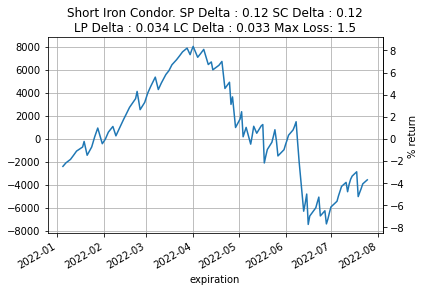

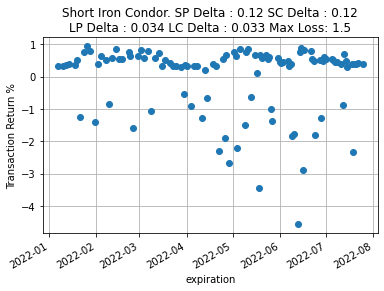

In [3]:
strat = StaticShortIronCondorDynamicMaxLossExitStrategy(commission,1,purchase_time,0.12,0.12, 0.034, 0.033, df_ty, initial_portfolio_value, None, 1.5, debug = True)
# strat = StaticShortIronCondorHoldToExpStrategy(commission,1,purchase_time,0.09,0.09, 0.01, 0.01, df_ty, initial_portfolio_value, debug = True)
# strat = StaticShortStraddleHoldToExpStrategy(commission,1,purchase_time,0.12,0.12, df_ty, initial_portfolio_value, debug = True)
sharp = strat.evaluate(df)

In [4]:
strat.df_trades.to_csv(f"{str(strat)}.csv")

In [5]:
def run_backtest(strat, df):
    return strat.evaluate(df)

In [6]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float("delta_sp", 0.002, 0.55)
#     delta_lp_trial = trial.suggest_float("delta_p_offset", 0.001, 0.5)
    delta_sc_trial = trial.suggest_float("delta_sc", 0.002, 0.55)
#     delta_lc_trial = trial.suggest_float("delta_c_offset", 0.001, 0.50)
#     max_loss = trial.suggest_float("max_loss", 1.25, 4.0)
   
    
    strategy = StaticShortStraddleHoldToExpStrategy(commission,1,purchase_time,delta_sp_trial,delta_sc_trial, df_ty, initial_portfolio_value)
    score = run_backtest(strategy, df)
    return score

In [7]:
study_name = "optimal-short-straddle-study_2021-2022_1DTE_1"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, purchase_time), n_trials = 200)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-05-22 20:24:37,544] Using an existing study with name 'optimal-short-straddle-study_2021-2022_1DTE_1' instead of creating a new one.
[I 2023-05-22 20:24:39,110] Trial 2 finished with value: 261.893 and parameters: {'delta_sp': 0.3130881627421294, 'delta_sc': 0.4782357465023817}. Best is trial 2 with value: 261.893.
[I 2023-05-22 20:24:40,610] Trial 3 finished with value: -459.296 and parameters: {'delta_sp': 0.22842886501157778, 'delta_sc': 0.2314433930336484}. Best is trial 2 with value: 261.893.
[I 2023-05-22 20:24:42,112] Trial 4 finished with value: -383.156 and parameters: {'delta_sp': 0.3413069771642287, 'delta_sc': 0.05283137557269491}. Best is trial 2 with value: 261.893.
[I 2023-05-22 20:24:43,687] Trial 5 finished with value: 472.61 and parameters: {'delta_sp': 0.0472387674128676, 'delta_sc': 0.3347020968732274}. Best is trial 5 with value: 472.61.
[I 2023-05-22 20:24:45,210] Trial 6 finished with value: 658.1 and parameters: {'delta_sp': 0.06673982218777937, 'delta_s

No records found: 2022-06-08 00:00:00, 2022-06-09 00:00:00
No records found: 2022-07-19 00:00:00, 2022-07-20 00:00:00


[I 2023-05-22 20:25:03,811] Trial 18 finished with value: -604.884 and parameters: {'delta_sp': 0.20534466908222637, 'delta_sc': 0.004286120982379141}. Best is trial 14 with value: 2204.951.
[I 2023-05-22 20:25:05,343] Trial 19 finished with value: 1781.934 and parameters: {'delta_sp': 0.009342712946202425, 'delta_sc': 0.09374903363676323}. Best is trial 14 with value: 2204.951.
[I 2023-05-22 20:25:06,857] Trial 20 finished with value: 391.053 and parameters: {'delta_sp': 0.08003046456874026, 'delta_sc': 0.0638920475666134}. Best is trial 14 with value: 2204.951.
[I 2023-05-22 20:25:08,396] Trial 21 finished with value: 1864.754 and parameters: {'delta_sp': 0.021234577513263922, 'delta_sc': 0.12070915961394245}. Best is trial 14 with value: 2204.951.
[I 2023-05-22 20:25:09,877] Trial 22 finished with value: 725.828 and parameters: {'delta_sp': 0.008971556732373038, 'delta_sc': 0.168931872278471}. Best is trial 14 with value: 2204.951.
[I 2023-05-22 20:25:11,377] Trial 23 finished with 

No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-02-11 00:00:00, 2022-02-14 00:00:00
No records found: 2022-02-15 00:00:00, 2022-02-16 00:00:00
No records found: 2022-03-04 00:00:00, 2022-03-07 00:00:00
No records found: 2022-03-08 00:00:00, 2022-03-09 00:00:00
No records found: 2022-04-14 00:00:00, 2022-04-18 00:00:00
No records found: 2022-04-22 00:00:00, 2022-04-25 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00
No records found: 2022-04-29 00:00:00, 2022-05-02 00:00:00
No records found: 2022-05-09 00:00:00, 2022-05-10 00:00:00
No records found: 2022-05-24 00:00:00, 2022-05-25 00:00:00
No records found: 2022-06-13 00:00:00, 2022-06-14 00:00:00
No records found: 2022-06-16 00:00:00, 2022-06-17 00:00:00


[I 2023-05-22 20:25:42,357] Trial 43 finished with value: 2737.621 and parameters: {'delta_sp': 0.0021767002582652444, 'delta_sc': 0.027342025812696936}. Best is trial 42 with value: 4486.136.
[I 2023-05-22 20:25:43,859] Trial 44 finished with value: 6583.1 and parameters: {'delta_sp': 0.007975460588781243, 'delta_sc': 0.02275864149991036}. Best is trial 44 with value: 6583.1.


No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00


[I 2023-05-22 20:25:45,379] Trial 45 finished with value: 2159.793 and parameters: {'delta_sp': 0.0027052397484688614, 'delta_sc': 0.03633426576299372}. Best is trial 44 with value: 6583.1.
[I 2023-05-22 20:25:46,899] Trial 46 finished with value: 122.487 and parameters: {'delta_sp': 0.080315640105277, 'delta_sc': 0.02717232698866963}. Best is trial 44 with value: 6583.1.
[I 2023-05-22 20:25:48,345] Trial 47 finished with value: 4951.454 and parameters: {'delta_sp': 0.005068405062883174, 'delta_sc': 0.020961810229491798}. Best is trial 44 with value: 6583.1.
[I 2023-05-22 20:25:49,830] Trial 48 finished with value: -489.634 and parameters: {'delta_sp': 0.533853781201308, 'delta_sc': 0.030968003309027853}. Best is trial 44 with value: 6583.1.
[I 2023-05-22 20:25:51,300] Trial 49 finished with value: -377.597 and parameters: {'delta_sp': 0.12848094488941325, 'delta_sc': 0.013403644341805297}. Best is trial 44 with value: 6583.1.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-02-01 00:00:00, 2022-02-02 00:00:00
No records found: 2022-03-25 00:00:00, 2022-03-28 00:00:00
No records found: 2022-03-29 00:00:00, 2022-03-30 00:00:00
No records found: 2022-04-07 00:00:00, 2022-04-08 00:00:00
No records found: 2022-06-07 00:00:00, 2022-06-08 00:00:00
No records found: 2022-06-08 00:00:00, 2022-06-09 00:00:00
No records found: 2022-07-06 00:00:00, 2022-07-07 00:00:00
No records found: 2022-07-19 00:00:00, 2022-07-20 00:00:00
No records found: 2022-07-21 00:00:00, 2022-07-22 00:00:00


[I 2023-05-22 20:25:52,796] Trial 50 finished with value: 280.621 and parameters: {'delta_sp': 0.053875882603575516, 'delta_sc': 0.003135135630195126}. Best is trial 44 with value: 6583.1.
[I 2023-05-22 20:25:54,293] Trial 51 finished with value: 2384.124 and parameters: {'delta_sp': 0.009095841157405703, 'delta_sc': 0.04687314566592535}. Best is trial 44 with value: 6583.1.
[I 2023-05-22 20:25:55,804] Trial 52 finished with value: 3575.278 and parameters: {'delta_sp': 0.02824666654160274, 'delta_sc': 0.05461565389143061}. Best is trial 44 with value: 6583.1.
[I 2023-05-22 20:25:57,336] Trial 53 finished with value: 3450.869 and parameters: {'delta_sp': 0.025575893011824502, 'delta_sc': 0.047315643607122954}. Best is trial 44 with value: 6583.1.
[I 2023-05-22 20:25:58,861] Trial 54 finished with value: 2687.3 and parameters: {'delta_sp': 0.03732736222665936, 'delta_sc': 0.055267087927434705}. Best is trial 44 with value: 6583.1.
[I 2023-05-22 20:26:00,360] Trial 55 finished with value:

No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-02-11 00:00:00, 2022-02-14 00:00:00
No records found: 2022-02-15 00:00:00, 2022-02-16 00:00:00
No records found: 2022-04-22 00:00:00, 2022-04-25 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00
No records found: 2022-05-09 00:00:00, 2022-05-10 00:00:00
No records found: 2022-06-13 00:00:00, 2022-06-14 00:00:00


[I 2023-05-22 20:26:08,277] Trial 60 finished with value: 1128.811 and parameters: {'delta_sp': 0.0023755846429577105, 'delta_sc': 0.11065491033779437}. Best is trial 44 with value: 6583.1.
[I 2023-05-22 20:26:09,793] Trial 61 finished with value: 2457.805 and parameters: {'delta_sp': 0.036764960924602755, 'delta_sc': 0.06815703163036294}. Best is trial 44 with value: 6583.1.
[I 2023-05-22 20:26:11,285] Trial 62 finished with value: 8764.231 and parameters: {'delta_sp': 0.022910250581326234, 'delta_sc': 0.021782043784382265}. Best is trial 62 with value: 8764.231.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-13 00:00:00, 2022-01-14 00:00:00
No records found: 2022-01-25 00:00:00, 2022-01-26 00:00:00
No records found: 2022-01-27 00:00:00, 2022-01-28 00:00:00
No records found: 2022-02-01 00:00:00, 2022-02-02 00:00:00
No records found: 2022-03-08 00:00:00, 2022-03-09 00:00:00
No records found: 2022-03-10 00:00:00, 2022-03-11 00:00:00
No records found: 2022-03-25 00:00:00, 2022-03-28 00:00:00
No records found: 2022-03-29 00:00:00, 2022-03-30 00:00:00
No records found: 2022-04-05 00:00:00, 2022-04-06 00:00:00
No records found: 2022-04-07 00:00:00, 2022-04-08 00:00:00
No records found: 2022-04-12 00:00:00, 2022-04-13 00:00:00
No records found: 2022-05-05 00:00:00, 2022-05-06 00:00:00
No records found: 2022-05-10 00:00:00, 2022-05-11 00:00:00
No records found: 2022-05-12 00:00:00, 2022-05-13 00:00:00
No records found: 2022-05-25 00:00:00, 2022-05-26 00:00:00
No records found: 2022-05-26 00:00:00, 2022-05-27 00:00:

[I 2023-05-22 20:26:12,756] Trial 63 finished with value: 27525.794 and parameters: {'delta_sp': 0.017701810552724805, 'delta_sc': 0.002264852238191454}. Best is trial 63 with value: 27525.794.
[I 2023-05-22 20:26:14,233] Trial 64 finished with value: 88.979 and parameters: {'delta_sp': 0.05897564518754214, 'delta_sc': 0.004909371262226028}. Best is trial 63 with value: 27525.794.
[I 2023-05-22 20:26:15,789] Trial 65 finished with value: 3943.064 and parameters: {'delta_sp': 0.021498499008386865, 'delta_sc': 0.043738026957344966}. Best is trial 63 with value: 27525.794.
[I 2023-05-22 20:26:17,377] Trial 66 finished with value: 70.805 and parameters: {'delta_sp': 0.08855580732509583, 'delta_sc': 0.01782716828798247}. Best is trial 63 with value: 27525.794.
[I 2023-05-22 20:26:18,898] Trial 67 finished with value: 2731.77 and parameters: {'delta_sp': 0.020751606364564787, 'delta_sc': 0.07354731325345093}. Best is trial 63 with value: 27525.794.
[I 2023-05-22 20:26:20,381] Trial 68 finish

No records found: 2022-06-08 00:00:00, 2022-06-09 00:00:00
No records found: 2022-07-19 00:00:00, 2022-07-20 00:00:00


[I 2023-05-22 20:26:27,847] Trial 73 finished with value: 486.698 and parameters: {'delta_sp': 0.04999530888076498, 'delta_sc': 0.003966865754959914}. Best is trial 63 with value: 27525.794.
[I 2023-05-22 20:26:29,310] Trial 74 finished with value: -248.081 and parameters: {'delta_sp': 0.1080183453724219, 'delta_sc': 0.021109671945137763}. Best is trial 63 with value: 27525.794.
[I 2023-05-22 20:26:30,789] Trial 75 finished with value: 2740.301 and parameters: {'delta_sp': 0.015797953488521577, 'delta_sc': 0.0618143798106805}. Best is trial 63 with value: 27525.794.
[I 2023-05-22 20:26:32,790] Trial 76 finished with value: 1680.381 and parameters: {'delta_sp': 0.043858104445714016, 'delta_sc': 0.037437910077744864}. Best is trial 63 with value: 27525.794.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-02-01 00:00:00, 2022-02-02 00:00:00
No records found: 2022-03-25 00:00:00, 2022-03-28 00:00:00
No records found: 2022-03-29 00:00:00, 2022-03-30 00:00:00
No records found: 2022-04-05 00:00:00, 2022-04-06 00:00:00
No records found: 2022-04-07 00:00:00, 2022-04-08 00:00:00
No records found: 2022-04-12 00:00:00, 2022-04-13 00:00:00
No records found: 2022-06-07 00:00:00, 2022-06-08 00:00:00
No records found: 2022-06-08 00:00:00, 2022-06-09 00:00:00
No records found: 2022-07-06 00:00:00, 2022-07-07 00:00:00
No records found: 2022-07-19 00:00:00, 2022-07-20 00:00:00
No records found: 2022-07-20 00:00:00, 2022-07-21 00:00:00
No records found: 2022-07-21 00:00:00, 2022-07-22 00:00:00


[I 2023-05-22 20:26:34,229] Trial 77 finished with value: 35.771 and parameters: {'delta_sp': 0.06467574429193669, 'delta_sc': 0.0027533311333737508}. Best is trial 63 with value: 27525.794.
[I 2023-05-22 20:26:35,736] Trial 78 finished with value: 2081.692 and parameters: {'delta_sp': 0.01898918678942603, 'delta_sc': 0.09746237147879691}. Best is trial 63 with value: 27525.794.
[I 2023-05-22 20:26:37,225] Trial 79 finished with value: -33.12 and parameters: {'delta_sp': 0.0954569627887508, 'delta_sc': 0.03550595643328205}. Best is trial 63 with value: 27525.794.
[I 2023-05-22 20:26:38,671] Trial 80 finished with value: 519.489 and parameters: {'delta_sp': 0.07828033096193529, 'delta_sc': 0.11798633043467274}. Best is trial 63 with value: 27525.794.
[I 2023-05-22 20:26:40,010] Trial 81 finished with value: 3378.832 and parameters: {'delta_sp': 0.029024839886404093, 'delta_sc': 0.05170288059362581}. Best is trial 63 with value: 27525.794.
[I 2023-05-22 20:26:41,470] Trial 82 finished wi

No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-13 00:00:00, 2022-01-14 00:00:00
No records found: 2022-01-25 00:00:00, 2022-01-26 00:00:00
No records found: 2022-01-27 00:00:00, 2022-01-28 00:00:00
No records found: 2022-02-01 00:00:00, 2022-02-02 00:00:00
No records found: 2022-03-03 00:00:00, 2022-03-04 00:00:00
No records found: 2022-03-08 00:00:00, 2022-03-09 00:00:00
No records found: 2022-03-10 00:00:00, 2022-03-11 00:00:00
No records found: 2022-03-15 00:00:00, 2022-03-16 00:00:00
No records found: 2022-03-25 00:00:00, 2022-03-28 00:00:00
No records found: 2022-03-29 00:00:00, 2022-03-30 00:00:00
No records found: 2022-04-05 00:00:00, 2022-04-06 00:00:00
No records found: 2022-04-07 00:00:00, 2022-04-08 00:00:00
No records found: 2022-04-12 00:00:00, 2022-04-13 00:00:00
No records found: 2022-04-28 00:00:00, 2022-04-29 00:00:00
No records found: 2022-05-05 00:00:00, 2022-05-06 00:00:00
No records found: 2022-05-10 00:00:00, 2022-05-11 00:00:

[I 2023-05-22 20:26:51,952] Trial 89 finished with value: 219.191 and parameters: {'delta_sp': 0.05501650615767306, 'delta_sc': 0.0020411335783148757}. Best is trial 63 with value: 27525.794.
[I 2023-05-22 20:26:53,467] Trial 90 finished with value: 2596.122 and parameters: {'delta_sp': 0.017833073408857616, 'delta_sc': 0.0780052030234208}. Best is trial 63 with value: 27525.794.
[I 2023-05-22 20:26:54,935] Trial 91 finished with value: 3644.396 and parameters: {'delta_sp': 0.0330013919855362, 'delta_sc': 0.028181203842961938}. Best is trial 63 with value: 27525.794.
[I 2023-05-22 20:26:56,416] Trial 92 finished with value: 2629.077 and parameters: {'delta_sp': 0.038389472155830134, 'delta_sc': 0.03856637614664703}. Best is trial 63 with value: 27525.794.
[I 2023-05-22 20:26:57,898] Trial 93 finished with value: 7262.164 and parameters: {'delta_sp': 0.015212104815071431, 'delta_sc': 0.023920342928189942}. Best is trial 63 with value: 27525.794.
[I 2023-05-22 20:26:59,378] Trial 94 fini

No records found: 2022-06-08 00:00:00, 2022-06-09 00:00:00
No records found: 2022-07-19 00:00:00, 2022-07-20 00:00:00


[I 2023-05-22 20:27:23,833] Trial 110 finished with value: 25735.597 and parameters: {'delta_sp': 0.021998132735497295, 'delta_sc': 0.003930717787381876}. Best is trial 94 with value: 32066.491.


No records found: 2022-07-19 00:00:00, 2022-07-20 00:00:00


[I 2023-05-22 20:27:25,311] Trial 111 finished with value: 12171.138 and parameters: {'delta_sp': 0.02238625046431645, 'delta_sc': 0.004330635210837972}. Best is trial 94 with value: 32066.491.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-02-11 00:00:00, 2022-02-14 00:00:00
No records found: 2022-02-15 00:00:00, 2022-02-16 00:00:00
No records found: 2022-04-22 00:00:00, 2022-04-25 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00
No records found: 2022-05-09 00:00:00, 2022-05-10 00:00:00
No records found: 2022-06-13 00:00:00, 2022-06-14 00:00:00


[I 2023-05-22 20:27:26,789] Trial 112 finished with value: 24558.111 and parameters: {'delta_sp': 0.0023953090247393442, 'delta_sc': 0.005354081785292841}. Best is trial 94 with value: 32066.491.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-18 00:00:00, 2022-01-19 00:00:00
No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-01-28 00:00:00, 2022-01-31 00:00:00
No records found: 2022-02-11 00:00:00, 2022-02-14 00:00:00
No records found: 2022-02-15 00:00:00, 2022-02-16 00:00:00
No records found: 2022-03-04 00:00:00, 2022-03-07 00:00:00
No records found: 2022-03-08 00:00:00, 2022-03-09 00:00:00
No records found: 2022-03-25 00:00:00, 2022-03-28 00:00:00
No records found: 2022-04-14 00:00:00, 2022-04-18 00:00:00
No records found: 2022-04-22 00:00:00, 2022-04-25 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00
No records found: 2022-04-29 00:00:00, 2022-05-02 00:00:00
No records found: 2022-05-09 00:00:00, 2022-05-10 00:00:00
No records found: 2022-05-18 00:00:00, 2022-05-19 00:00:00
No records found: 2022-05-24 00:00:00, 2022-05-25 00:00:00
No records found: 2022-06-13 00:00:00, 2022-06-14 00:00:

[I 2023-05-22 20:27:28,229] Trial 113 finished with value: 24268.663 and parameters: {'delta_sp': 0.002075383804567267, 'delta_sc': 0.005587409311114785}. Best is trial 94 with value: 32066.491.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-02-11 00:00:00, 2022-02-14 00:00:00
No records found: 2022-02-15 00:00:00, 2022-02-16 00:00:00
No records found: 2022-04-22 00:00:00, 2022-04-25 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00
No records found: 2022-05-09 00:00:00, 2022-05-10 00:00:00
No records found: 2022-06-13 00:00:00, 2022-06-14 00:00:00


[I 2023-05-22 20:27:29,692] Trial 114 finished with value: 23938.406 and parameters: {'delta_sp': 0.002477716481424263, 'delta_sc': 0.005197174984367133}. Best is trial 94 with value: 32066.491.


No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-02-11 00:00:00, 2022-02-14 00:00:00
No records found: 2022-02-15 00:00:00, 2022-02-16 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00
No records found: 2022-05-09 00:00:00, 2022-05-10 00:00:00


[I 2023-05-22 20:27:31,175] Trial 115 finished with value: 2903.525 and parameters: {'delta_sp': 0.0026137041813644943, 'delta_sc': 0.032111266411503234}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:27:32,676] Trial 116 finished with value: 3111.803 and parameters: {'delta_sp': 0.012009211021732843, 'delta_sc': 0.04494801811164839}. Best is trial 94 with value: 32066.491.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-02-11 00:00:00, 2022-02-14 00:00:00
No records found: 2022-02-15 00:00:00, 2022-02-16 00:00:00
No records found: 2022-03-08 00:00:00, 2022-03-09 00:00:00
No records found: 2022-04-22 00:00:00, 2022-04-25 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00
No records found: 2022-04-29 00:00:00, 2022-05-02 00:00:00
No records found: 2022-05-09 00:00:00, 2022-05-10 00:00:00
No records found: 2022-06-13 00:00:00, 2022-06-14 00:00:00


[I 2023-05-22 20:27:34,179] Trial 117 finished with value: 1558.618 and parameters: {'delta_sp': 0.0022298443694824116, 'delta_sc': 0.061358782037887916}. Best is trial 94 with value: 32066.491.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-02-01 00:00:00, 2022-02-02 00:00:00
No records found: 2022-03-25 00:00:00, 2022-03-28 00:00:00
No records found: 2022-03-29 00:00:00, 2022-03-30 00:00:00
No records found: 2022-04-05 00:00:00, 2022-04-06 00:00:00
No records found: 2022-04-07 00:00:00, 2022-04-08 00:00:00
No records found: 2022-06-07 00:00:00, 2022-06-08 00:00:00
No records found: 2022-06-08 00:00:00, 2022-06-09 00:00:00
No records found: 2022-07-06 00:00:00, 2022-07-07 00:00:00
No records found: 2022-07-19 00:00:00, 2022-07-20 00:00:00
No records found: 2022-07-20 00:00:00, 2022-07-21 00:00:00
No records found: 2022-07-21 00:00:00, 2022-07-22 00:00:00


[I 2023-05-22 20:27:35,658] Trial 118 finished with value: 1784.765 and parameters: {'delta_sp': 0.03890955960009886, 'delta_sc': 0.0029641946207123043}. Best is trial 94 with value: 32066.491.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-13 00:00:00, 2022-01-14 00:00:00
No records found: 2022-01-25 00:00:00, 2022-01-26 00:00:00
No records found: 2022-01-27 00:00:00, 2022-01-28 00:00:00
No records found: 2022-02-01 00:00:00, 2022-02-02 00:00:00
No records found: 2022-03-03 00:00:00, 2022-03-04 00:00:00
No records found: 2022-03-08 00:00:00, 2022-03-09 00:00:00
No records found: 2022-03-10 00:00:00, 2022-03-11 00:00:00
No records found: 2022-03-15 00:00:00, 2022-03-16 00:00:00
No records found: 2022-03-25 00:00:00, 2022-03-28 00:00:00
No records found: 2022-03-29 00:00:00, 2022-03-30 00:00:00
No records found: 2022-04-05 00:00:00, 2022-04-06 00:00:00
No records found: 2022-04-07 00:00:00, 2022-04-08 00:00:00
No records found: 2022-04-12 00:00:00, 2022-04-13 00:00:00
No records found: 2022-04-28 00:00:00, 2022-04-29 00:00:00
No records found: 2022-05-05 00:00:00, 2022-05-06 00:00:00
No records found: 2022-05-10 00:00:00, 2022-05-11 00:00:

[I 2023-05-22 20:27:37,113] Trial 119 finished with value: 439.525 and parameters: {'delta_sp': 0.05049631079308954, 'delta_sc': 0.0020723810377196055}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:27:38,615] Trial 120 finished with value: -494.747 and parameters: {'delta_sp': 0.19005935263275378, 'delta_sc': 0.030171326459252957}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:27:40,118] Trial 121 finished with value: 335.191 and parameters: {'delta_sp': 0.012721789366395585, 'delta_sc': 0.2570860342069307}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:27:41,575] Trial 122 finished with value: 7766.289 and parameters: {'delta_sp': 0.0274074351793394, 'delta_sc': 0.008307419545994897}. Best is trial 94 with value: 32066.491.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-13 00:00:00, 2022-01-14 00:00:00
No records found: 2022-01-25 00:00:00, 2022-01-26 00:00:00
No records found: 2022-01-27 00:00:00, 2022-01-28 00:00:00
No records found: 2022-02-01 00:00:00, 2022-02-02 00:00:00
No records found: 2022-03-08 00:00:00, 2022-03-09 00:00:00
No records found: 2022-03-10 00:00:00, 2022-03-11 00:00:00
No records found: 2022-03-25 00:00:00, 2022-03-28 00:00:00
No records found: 2022-03-29 00:00:00, 2022-03-30 00:00:00
No records found: 2022-04-05 00:00:00, 2022-04-06 00:00:00
No records found: 2022-04-07 00:00:00, 2022-04-08 00:00:00
No records found: 2022-04-12 00:00:00, 2022-04-13 00:00:00
No records found: 2022-05-10 00:00:00, 2022-05-11 00:00:00
No records found: 2022-05-12 00:00:00, 2022-05-13 00:00:00
No records found: 2022-05-26 00:00:00, 2022-05-27 00:00:00
No records found: 2022-06-07 00:00:00, 2022-06-08 00:00:00
No records found: 2022-06-08 00:00:00, 2022-06-09 00:00:

[I 2023-05-22 20:27:43,030] Trial 123 finished with value: 27710.711 and parameters: {'delta_sp': 0.013433545661236522, 'delta_sc': 0.002357020944857807}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:27:44,590] Trial 124 finished with value: 408.141 and parameters: {'delta_sp': 0.010925385255516562, 'delta_sc': 0.3065040237691941}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:27:46,088] Trial 125 finished with value: 2801.246 and parameters: {'delta_sp': 0.038534469297457956, 'delta_sc': 0.0160002769095453}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:27:47,594] Trial 126 finished with value: 583.034 and parameters: {'delta_sp': 0.06465839269747595, 'delta_sc': 0.040270619552331924}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:27:49,108] Trial 127 finished with value: -354.717 and parameters: {'delta_sp': 0.2601714321554811, 'delta_sc': 0.054989067752922435}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:27:50,613] Trial 128 

No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-13 00:00:00, 2022-01-14 00:00:00
No records found: 2022-01-25 00:00:00, 2022-01-26 00:00:00
No records found: 2022-01-27 00:00:00, 2022-01-28 00:00:00
No records found: 2022-02-01 00:00:00, 2022-02-02 00:00:00
No records found: 2022-03-08 00:00:00, 2022-03-09 00:00:00
No records found: 2022-03-10 00:00:00, 2022-03-11 00:00:00
No records found: 2022-03-15 00:00:00, 2022-03-16 00:00:00
No records found: 2022-03-25 00:00:00, 2022-03-28 00:00:00
No records found: 2022-03-29 00:00:00, 2022-03-30 00:00:00
No records found: 2022-04-05 00:00:00, 2022-04-06 00:00:00
No records found: 2022-04-07 00:00:00, 2022-04-08 00:00:00
No records found: 2022-04-12 00:00:00, 2022-04-13 00:00:00
No records found: 2022-04-28 00:00:00, 2022-04-29 00:00:00
No records found: 2022-05-05 00:00:00, 2022-05-06 00:00:00
No records found: 2022-05-10 00:00:00, 2022-05-11 00:00:00
No records found: 2022-05-12 00:00:00, 2022-05-13 00:00:

[I 2023-05-22 20:27:57,477] Trial 132 finished with value: 26571.194 and parameters: {'delta_sp': 0.014791886594275607, 'delta_sc': 0.00213943497265862}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:27:58,960] Trial 133 finished with value: 30854.321 and parameters: {'delta_sp': 0.020813271088517202, 'delta_sc': 0.016475852029251854}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:28:00,452] Trial 134 finished with value: 1584.91 and parameters: {'delta_sp': 0.04677121127869246, 'delta_sc': 0.01807480367140314}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:28:01,959] Trial 135 finished with value: 6628.33 and parameters: {'delta_sp': 0.021824362620601938, 'delta_sc': 0.026037530778059495}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:28:03,460] Trial 136 finished with value: 3383.877 and parameters: {'delta_sp': 0.03479855023954985, 'delta_sc': 0.04425460604564946}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:28:04,942] Trial 1

No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-13 00:00:00, 2022-01-14 00:00:00
No records found: 2022-01-25 00:00:00, 2022-01-26 00:00:00
No records found: 2022-01-27 00:00:00, 2022-01-28 00:00:00
No records found: 2022-02-01 00:00:00, 2022-02-02 00:00:00
No records found: 2022-03-08 00:00:00, 2022-03-09 00:00:00
No records found: 2022-03-10 00:00:00, 2022-03-11 00:00:00
No records found: 2022-03-15 00:00:00, 2022-03-16 00:00:00
No records found: 2022-03-25 00:00:00, 2022-03-28 00:00:00
No records found: 2022-03-29 00:00:00, 2022-03-30 00:00:00
No records found: 2022-04-05 00:00:00, 2022-04-06 00:00:00
No records found: 2022-04-07 00:00:00, 2022-04-08 00:00:00
No records found: 2022-04-12 00:00:00, 2022-04-13 00:00:00
No records found: 2022-04-28 00:00:00, 2022-04-29 00:00:00
No records found: 2022-05-05 00:00:00, 2022-05-06 00:00:00
No records found: 2022-05-10 00:00:00, 2022-05-11 00:00:00
No records found: 2022-05-12 00:00:00, 2022-05-13 00:00:

[I 2023-05-22 20:28:07,893] Trial 139 finished with value: 6633.328 and parameters: {'delta_sp': 0.027585438725695202, 'delta_sc': 0.0021877473575875293}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:28:09,381] Trial 140 finished with value: 1859.127 and parameters: {'delta_sp': 0.04558094911166131, 'delta_sc': 0.05186863521458783}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:28:10,895] Trial 141 finished with value: 15867.286 and parameters: {'delta_sp': 0.014407417876412854, 'delta_sc': 0.01898139308464905}. Best is trial 94 with value: 32066.491.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-02-11 00:00:00, 2022-02-14 00:00:00
No records found: 2022-02-15 00:00:00, 2022-02-16 00:00:00
No records found: 2022-03-08 00:00:00, 2022-03-09 00:00:00
No records found: 2022-04-22 00:00:00, 2022-04-25 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00
No records found: 2022-04-29 00:00:00, 2022-05-02 00:00:00
No records found: 2022-05-09 00:00:00, 2022-05-10 00:00:00
No records found: 2022-06-13 00:00:00, 2022-06-14 00:00:00


[I 2023-05-22 20:28:12,364] Trial 142 finished with value: 31237.865 and parameters: {'delta_sp': 0.0022243015080651365, 'delta_sc': 0.012405813628029111}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:28:13,827] Trial 143 finished with value: 15481.96 and parameters: {'delta_sp': 0.02337563245373133, 'delta_sc': 0.012352038466451937}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:28:15,342] Trial 144 finished with value: 3571.033 and parameters: {'delta_sp': 0.035416430507769735, 'delta_sc': 0.025604712191279928}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:28:16,855] Trial 145 finished with value: 4020.625 and parameters: {'delta_sp': 0.014353970145325023, 'delta_sc': 0.03887169553068344}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:28:18,354] Trial 146 finished with value: 16240.319 and parameters: {'delta_sp': 0.023294689510005465, 'delta_sc': 0.01440324504568223}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:28:19,859] Tr

No records found: 2022-06-08 00:00:00, 2022-06-09 00:00:00
No records found: 2022-07-19 00:00:00, 2022-07-20 00:00:00


[I 2023-05-22 20:28:25,895] Trial 151 finished with value: 26908.104 and parameters: {'delta_sp': 0.011574450100422965, 'delta_sc': 0.004229711713049797}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:28:27,382] Trial 152 finished with value: 4913.741 and parameters: {'delta_sp': 0.012364805081884457, 'delta_sc': 0.02593954878304132}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:28:28,857] Trial 153 finished with value: 5852.941 and parameters: {'delta_sp': 0.030118639662852248, 'delta_sc': 0.012610641564033652}. Best is trial 94 with value: 32066.491.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-13 00:00:00, 2022-01-14 00:00:00
No records found: 2022-01-25 00:00:00, 2022-01-26 00:00:00
No records found: 2022-01-27 00:00:00, 2022-01-28 00:00:00
No records found: 2022-02-01 00:00:00, 2022-02-02 00:00:00
No records found: 2022-03-08 00:00:00, 2022-03-09 00:00:00
No records found: 2022-03-10 00:00:00, 2022-03-11 00:00:00
No records found: 2022-03-25 00:00:00, 2022-03-28 00:00:00
No records found: 2022-03-29 00:00:00, 2022-03-30 00:00:00
No records found: 2022-04-05 00:00:00, 2022-04-06 00:00:00
No records found: 2022-04-07 00:00:00, 2022-04-08 00:00:00
No records found: 2022-04-12 00:00:00, 2022-04-13 00:00:00
No records found: 2022-05-05 00:00:00, 2022-05-06 00:00:00
No records found: 2022-05-10 00:00:00, 2022-05-11 00:00:00
No records found: 2022-05-12 00:00:00, 2022-05-13 00:00:00
No records found: 2022-05-25 00:00:00, 2022-05-26 00:00:00
No records found: 2022-05-26 00:00:00, 2022-05-27 00:00:

[I 2023-05-22 20:28:30,292] Trial 154 finished with value: 27502.732 and parameters: {'delta_sp': 0.013712707773825994, 'delta_sc': 0.002214061968246024}. Best is trial 94 with value: 32066.491.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-13 00:00:00, 2022-01-14 00:00:00
No records found: 2022-01-25 00:00:00, 2022-01-26 00:00:00
No records found: 2022-01-27 00:00:00, 2022-01-28 00:00:00
No records found: 2022-02-01 00:00:00, 2022-02-02 00:00:00
No records found: 2022-03-08 00:00:00, 2022-03-09 00:00:00
No records found: 2022-03-10 00:00:00, 2022-03-11 00:00:00
No records found: 2022-03-15 00:00:00, 2022-03-16 00:00:00
No records found: 2022-03-25 00:00:00, 2022-03-28 00:00:00
No records found: 2022-03-29 00:00:00, 2022-03-30 00:00:00
No records found: 2022-04-05 00:00:00, 2022-04-06 00:00:00
No records found: 2022-04-07 00:00:00, 2022-04-08 00:00:00
No records found: 2022-04-12 00:00:00, 2022-04-13 00:00:00
No records found: 2022-04-28 00:00:00, 2022-04-29 00:00:00
No records found: 2022-05-05 00:00:00, 2022-05-06 00:00:00
No records found: 2022-05-10 00:00:00, 2022-05-11 00:00:00
No records found: 2022-05-12 00:00:00, 2022-05-13 00:00:

[I 2023-05-22 20:28:31,726] Trial 155 finished with value: 27253.626 and parameters: {'delta_sp': 0.013263856515901899, 'delta_sc': 0.002197501738831523}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:28:33,207] Trial 156 finished with value: 3089.353 and parameters: {'delta_sp': 0.010231290317181533, 'delta_sc': 0.03462302673413954}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:28:34,692] Trial 157 finished with value: 2825.748 and parameters: {'delta_sp': 0.03897555350258043, 'delta_sc': 0.02244606743753461}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:28:36,199] Trial 158 finished with value: 3367.082 and parameters: {'delta_sp': 0.022813545783902208, 'delta_sc': 0.052665704315527674}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:28:37,710] Trial 159 finished with value: 654.757 and parameters: {'delta_sp': 0.003233090827621392, 'delta_sc': 0.15468209856155757}. Best is trial 94 with value: 32066.491.
[I 2023-05-22 20:28:39,217] Trial 

No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-02-11 00:00:00, 2022-02-14 00:00:00
No records found: 2022-02-15 00:00:00, 2022-02-16 00:00:00
No records found: 2022-03-08 00:00:00, 2022-03-09 00:00:00
No records found: 2022-04-22 00:00:00, 2022-04-25 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00
No records found: 2022-04-29 00:00:00, 2022-05-02 00:00:00
No records found: 2022-05-09 00:00:00, 2022-05-10 00:00:00
No records found: 2022-06-13 00:00:00, 2022-06-14 00:00:00


[I 2023-05-22 20:28:42,236] Trial 162 finished with value: 32238.872 and parameters: {'delta_sp': 0.0022387502903142287, 'delta_sc': 0.016482399379561967}. Best is trial 162 with value: 32238.872.
[I 2023-05-22 20:28:43,740] Trial 163 finished with value: 30265.054 and parameters: {'delta_sp': 0.020347494323172347, 'delta_sc': 0.014683766446002392}. Best is trial 162 with value: 32238.872.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-02-11 00:00:00, 2022-02-14 00:00:00
No records found: 2022-02-15 00:00:00, 2022-02-16 00:00:00
No records found: 2022-04-22 00:00:00, 2022-04-25 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00
No records found: 2022-05-09 00:00:00, 2022-05-10 00:00:00
No records found: 2022-06-13 00:00:00, 2022-06-14 00:00:00


[I 2023-05-22 20:28:45,221] Trial 164 finished with value: 8107.852 and parameters: {'delta_sp': 0.0023154121583182155, 'delta_sc': 0.01781729187707464}. Best is trial 162 with value: 32238.872.
[I 2023-05-22 20:28:47,708] Trial 165 finished with value: 4241.504 and parameters: {'delta_sp': 0.02394811334794294, 'delta_sc': 0.03364535618237646}. Best is trial 162 with value: 32238.872.
[I 2023-05-22 20:28:49,206] Trial 166 finished with value: 1532.936 and parameters: {'delta_sp': 0.04365560332968643, 'delta_sc': 0.015139699573806904}. Best is trial 162 with value: 32238.872.
[I 2023-05-22 20:28:50,804] Trial 167 finished with value: 5794.281 and parameters: {'delta_sp': 0.02158759054907363, 'delta_sc': 0.028833432257135794}. Best is trial 162 with value: 32238.872.
[I 2023-05-22 20:28:52,346] Trial 168 finished with value: 2880.834 and parameters: {'delta_sp': 0.03533172323786811, 'delta_sc': 0.04042772818985026}. Best is trial 162 with value: 32238.872.
[I 2023-05-22 20:28:53,906] Tri

No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-02-11 00:00:00, 2022-02-14 00:00:00
No records found: 2022-02-15 00:00:00, 2022-02-16 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00
No records found: 2022-05-09 00:00:00, 2022-05-10 00:00:00


[I 2023-05-22 20:28:55,452] Trial 170 finished with value: 30549.382 and parameters: {'delta_sp': 0.0025300594397185, 'delta_sc': 0.012176802835785695}. Best is trial 162 with value: 32238.872.
[I 2023-05-22 20:28:56,974] Trial 171 finished with value: 31089.499 and parameters: {'delta_sp': 0.01173843630961971, 'delta_sc': 0.012328914747954792}. Best is trial 162 with value: 32238.872.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-02-11 00:00:00, 2022-02-14 00:00:00
No records found: 2022-02-15 00:00:00, 2022-02-16 00:00:00
No records found: 2022-04-22 00:00:00, 2022-04-25 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00
No records found: 2022-05-09 00:00:00, 2022-05-10 00:00:00
No records found: 2022-06-13 00:00:00, 2022-06-14 00:00:00


[I 2023-05-22 20:28:58,512] Trial 172 finished with value: 32388.067 and parameters: {'delta_sp': 0.0024652671680952063, 'delta_sc': 0.012810417698721772}. Best is trial 172 with value: 32388.067.
[I 2023-05-22 20:28:59,975] Trial 173 finished with value: 3903.052 and parameters: {'delta_sp': 0.003006680254517946, 'delta_sc': 0.024888364400478678}. Best is trial 172 with value: 32388.067.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-02-11 00:00:00, 2022-02-14 00:00:00
No records found: 2022-02-15 00:00:00, 2022-02-16 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00
No records found: 2022-05-09 00:00:00, 2022-05-10 00:00:00


[I 2023-05-22 20:29:01,460] Trial 174 finished with value: 31750.936 and parameters: {'delta_sp': 0.0025554205055616456, 'delta_sc': 0.013163268551477912}. Best is trial 172 with value: 32388.067.
[I 2023-05-22 20:29:02,955] Trial 175 finished with value: 2941.951 and parameters: {'delta_sp': 0.010979036115707936, 'delta_sc': 0.04636651768586532}. Best is trial 172 with value: 32388.067.
[I 2023-05-22 20:29:04,462] Trial 176 finished with value: 30900.372 and parameters: {'delta_sp': 0.0030542632330764134, 'delta_sc': 0.013841103010784079}. Best is trial 172 with value: 32388.067.
[I 2023-05-22 20:29:05,958] Trial 177 finished with value: 4221.6 and parameters: {'delta_sp': 0.028283681663557866, 'delta_sc': 0.03273897357981381}. Best is trial 172 with value: 32388.067.
[I 2023-05-22 20:29:07,479] Trial 178 finished with value: 1865.854 and parameters: {'delta_sp': 0.004172848171978745, 'delta_sc': 0.06101699975267094}. Best is trial 172 with value: 32388.067.
[I 2023-05-22 20:29:08,972

No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-18 00:00:00, 2022-01-19 00:00:00
No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-01-28 00:00:00, 2022-01-31 00:00:00
No records found: 2022-02-11 00:00:00, 2022-02-14 00:00:00
No records found: 2022-02-15 00:00:00, 2022-02-16 00:00:00
No records found: 2022-03-04 00:00:00, 2022-03-07 00:00:00
No records found: 2022-03-08 00:00:00, 2022-03-09 00:00:00
No records found: 2022-03-25 00:00:00, 2022-03-28 00:00:00
No records found: 2022-04-14 00:00:00, 2022-04-18 00:00:00
No records found: 2022-04-22 00:00:00, 2022-04-25 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00
No records found: 2022-04-29 00:00:00, 2022-05-02 00:00:00
No records found: 2022-05-09 00:00:00, 2022-05-10 00:00:00
No records found: 2022-05-18 00:00:00, 2022-05-19 00:00:00
No records found: 2022-05-24 00:00:00, 2022-05-25 00:00:00
No records found: 2022-06-13 00:00:00, 2022-06-14 00:00:

[I 2023-05-22 20:29:11,908] Trial 181 finished with value: 32471.261 and parameters: {'delta_sp': 0.002065818030609061, 'delta_sc': 0.01402531588804388}. Best is trial 179 with value: 33261.224.
[I 2023-05-22 20:29:13,432] Trial 182 finished with value: 2762.432 and parameters: {'delta_sp': 0.003416419074185651, 'delta_sc': 0.025318070658949136}. Best is trial 179 with value: 33261.224.
[I 2023-05-22 20:29:14,931] Trial 183 finished with value: 4282.409 and parameters: {'delta_sp': 0.017286049007644924, 'delta_sc': 0.03602395870128323}. Best is trial 179 with value: 33261.224.
[I 2023-05-22 20:29:16,445] Trial 184 finished with value: 32052.302 and parameters: {'delta_sp': 0.003430237764804462, 'delta_sc': 0.014612408333137568}. Best is trial 179 with value: 33261.224.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-02-11 00:00:00, 2022-02-14 00:00:00
No records found: 2022-02-15 00:00:00, 2022-02-16 00:00:00
No records found: 2022-03-04 00:00:00, 2022-03-07 00:00:00
No records found: 2022-03-08 00:00:00, 2022-03-09 00:00:00
No records found: 2022-04-14 00:00:00, 2022-04-18 00:00:00
No records found: 2022-04-22 00:00:00, 2022-04-25 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00
No records found: 2022-04-29 00:00:00, 2022-05-02 00:00:00
No records found: 2022-05-09 00:00:00, 2022-05-10 00:00:00
No records found: 2022-05-24 00:00:00, 2022-05-25 00:00:00
No records found: 2022-06-13 00:00:00, 2022-06-14 00:00:00
No records found: 2022-06-16 00:00:00, 2022-06-17 00:00:00


[I 2023-05-22 20:29:17,968] Trial 185 finished with value: 8218.376 and parameters: {'delta_sp': 0.0021688604680599423, 'delta_sc': 0.018660695310450885}. Best is trial 179 with value: 33261.224.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-02-11 00:00:00, 2022-02-14 00:00:00
No records found: 2022-02-15 00:00:00, 2022-02-16 00:00:00
No records found: 2022-04-22 00:00:00, 2022-04-25 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00
No records found: 2022-05-09 00:00:00, 2022-05-10 00:00:00
No records found: 2022-06-13 00:00:00, 2022-06-14 00:00:00


[I 2023-05-22 20:29:19,455] Trial 186 finished with value: 230.444 and parameters: {'delta_sp': 0.0023284088869624958, 'delta_sc': 0.18559042456038238}. Best is trial 179 with value: 33261.224.
[I 2023-05-22 20:29:20,976] Trial 187 finished with value: 3507.44 and parameters: {'delta_sp': 0.030413339594115203, 'delta_sc': 0.04329023255197642}. Best is trial 179 with value: 33261.224.
[I 2023-05-22 20:29:22,447] Trial 188 finished with value: 1186.978 and parameters: {'delta_sp': 0.013825337523079993, 'delta_sc': 0.4879218334059691}. Best is trial 179 with value: 33261.224.
[I 2023-05-22 20:29:23,920] Trial 189 finished with value: 16033.051 and parameters: {'delta_sp': 0.023057530148727662, 'delta_sc': 0.014208184979820345}. Best is trial 179 with value: 33261.224.
[I 2023-05-22 20:29:25,456] Trial 190 finished with value: 4578.757 and parameters: {'delta_sp': 0.012620842898641706, 'delta_sc': 0.03016181288453443}. Best is trial 179 with value: 33261.224.
[I 2023-05-22 20:29:26,968] Tr

No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-02-11 00:00:00, 2022-02-14 00:00:00
No records found: 2022-02-15 00:00:00, 2022-02-16 00:00:00
No records found: 2022-03-08 00:00:00, 2022-03-09 00:00:00
No records found: 2022-04-22 00:00:00, 2022-04-25 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00
No records found: 2022-04-29 00:00:00, 2022-05-02 00:00:00
No records found: 2022-05-09 00:00:00, 2022-05-10 00:00:00
No records found: 2022-06-13 00:00:00, 2022-06-14 00:00:00


[I 2023-05-22 20:29:32,900] Trial 195 finished with value: 1744.998 and parameters: {'delta_sp': 0.002256650597557998, 'delta_sc': 0.033088164838766976}. Best is trial 179 with value: 33261.224.
[I 2023-05-22 20:29:34,380] Trial 196 finished with value: 7005.483 and parameters: {'delta_sp': 0.027979191251892035, 'delta_sc': 0.020903948818897046}. Best is trial 179 with value: 33261.224.


No records found: 2022-01-11 00:00:00, 2022-01-12 00:00:00
No records found: 2022-01-18 00:00:00, 2022-01-19 00:00:00
No records found: 2022-01-21 00:00:00, 2022-01-24 00:00:00
No records found: 2022-01-28 00:00:00, 2022-01-31 00:00:00
No records found: 2022-02-11 00:00:00, 2022-02-14 00:00:00
No records found: 2022-02-15 00:00:00, 2022-02-16 00:00:00
No records found: 2022-03-04 00:00:00, 2022-03-07 00:00:00
No records found: 2022-03-08 00:00:00, 2022-03-09 00:00:00
No records found: 2022-03-25 00:00:00, 2022-03-28 00:00:00
No records found: 2022-04-14 00:00:00, 2022-04-18 00:00:00
No records found: 2022-04-22 00:00:00, 2022-04-25 00:00:00
No records found: 2022-04-26 00:00:00, 2022-04-27 00:00:00
No records found: 2022-04-29 00:00:00, 2022-05-02 00:00:00
No records found: 2022-05-09 00:00:00, 2022-05-10 00:00:00
No records found: 2022-05-18 00:00:00, 2022-05-19 00:00:00
No records found: 2022-05-24 00:00:00, 2022-05-25 00:00:00
No records found: 2022-06-13 00:00:00, 2022-06-14 00:00:

[I 2023-05-22 20:29:35,873] Trial 197 finished with value: 1648.533 and parameters: {'delta_sp': 0.0020900030773820305, 'delta_sc': 0.041608620264850245}. Best is trial 179 with value: 33261.224.
[I 2023-05-22 20:29:37,352] Trial 198 finished with value: 1846.079 and parameters: {'delta_sp': 0.040831206176998355, 'delta_sc': 0.013012788901919998}. Best is trial 179 with value: 33261.224.
[I 2023-05-22 20:29:38,833] Trial 199 finished with value: 5413.83 and parameters: {'delta_sp': 0.014944638033935769, 'delta_sc': 0.025609230625218415}. Best is trial 179 with value: 33261.224.
[I 2023-05-22 20:29:40,329] Trial 200 finished with value: 3315.019 and parameters: {'delta_sp': 0.023027783631997985, 'delta_sc': 0.05158989049873347}. Best is trial 179 with value: 33261.224.
[I 2023-05-22 20:29:41,822] Trial 201 finished with value: 31350.74 and parameters: {'delta_sp': 0.012659580985043918, 'delta_sc': 0.011279315245758708}. Best is trial 179 with value: 33261.224.


Best Score:  33261.224
Best Params: 
  delta_sc: 0.015954629300243665
  delta_sp: 0.003266018056050951
